In [72]:
import glob
import os
import sys
import pickle
import re
import multiprocessing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.utils.data

import seaborn as sns
sns.set_theme()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
%pwd

'/home/isaiah/Documents/PRG/TransVAE/frozen/content'

In [2]:
BASE_PATH = '/home/isaiah/Documents/PRG/TransVAE/frozen/'
DATA_PATH = BASE_PATH + 'content/'
os.chdir(DATA_PATH)

# need to download pt_util from pjreddie
import pt_util

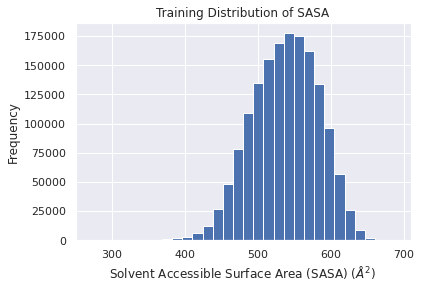

In [20]:
train_df = pd.read_csv(f'{BASE_PATH}../data/zinc_train.csv')
train_df.hist('sasa_area', bins=30)
plt.ylabel('Frequency')
plt.xlabel('Solvent Accessible Surface Area (SASA) $(\AA^2)$')
plt.title('Training Distribution of SASA')
plt.savefig('sasa_area_dist.svg', bbox_inches='tight')

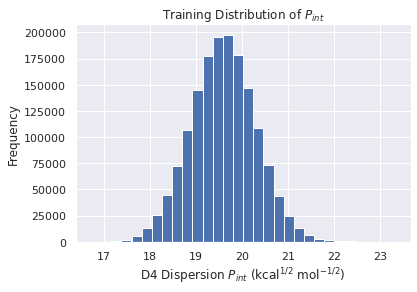

In [19]:
train_df.hist('d4_disp_pint', bins=30)
plt.ylabel('Frequency')
plt.xlabel('D4 Dispersion $P_{int}$ (kcal$^{1/2}$ mol$^{-1/2}$)')
plt.title('Training Distribution of $P_{int}$')
plt.savefig('d4_disp_pint_dist.svg', bbox_inches='tight')

In [4]:
class Net(nn.Module):
    def __init__(self, reconstruct_func):
        super(Net, self).__init__()
        input_size = 128
        hidden_size = 256
        self.best_loss = float('inf')
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.norm1 =nn.BatchNorm1d(hidden_size)
        self.norm2 =nn.BatchNorm1d(hidden_size)
        
        self.reconstruct_func = reconstruct_func

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.norm1(F.relu(x))
        x = self.fc2(x)
        x = self.norm2(F.relu(x))
        x = self.fc3(x)
        return x
    
    def loss(self, prediction, label):
        loss_val = F.mse_loss(torch.flatten(prediction), torch.flatten(label))
        return loss_val
    
    def comparable_loss(self, model_output, label):
        return self.loss(self.reconstruct_func(model_output), self.reconstruct_func(label))

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, loss, file_path, num_to_keep=1):
        if loss < self.best_loss:
            self.save_model(file_path, num_to_keep)
            self.best_loss = loss

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [5]:
def train(model, device, optimizer, train_loader, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    test_loss_comparable = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += model.loss(output, label).item()
            test_loss_comparable += model.comparable_loss(output, label).item()

    test_loss /= len(test_loader)
    test_loss_comparable /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Average comparable {:.4f}\n'.format(test_loss, test_loss_comparable))
    return test_loss, test_loss_comparable

In [6]:
def get_datasets(feature, norm_method=None):
    train_mem_arr = np.load(f'{BASE_PATH}zinc_train_red_mems.npy')
    test_mem_arr = np.load(f'{BASE_PATH}zinc_test_mems.npy')

    train_labels = pd.read_csv(f'{BASE_PATH}../data/zinc_train.csv', usecols=[feature])[feature]
    test_labels = pd.read_csv(f'{BASE_PATH}../data/zinc_test.csv', usecols=[feature])[feature]
    
    if norm_method == 'z_std':
        train_mean = train_labels.mean()
        train_std = train_labels.std()
        
        train_labels = (train_labels - train_mean) / train_std
        test_labels = (test_labels - train_mean) / train_std
        
        reconstruct = lambda x: (x * train_std) + train_mean
        
    elif norm_method == 'min_max':
        train_max = train_labels.max()
        train_min = train_labels.min()
        
        train_labels = (train_labels - train_min) / (train_max - train_min)
        test_labels = (test_labels - train_min) / (train_max - train_min)
        
        reconstruct = lambda x: (x * (train_max - train_min)) + train_min
        
    else:
        reconstruct = lambda x: x
        
    
    return (torch.utils.data.TensorDataset(torch.tensor(train_mem_arr).float(), torch.tensor(train_labels).float()), 
            torch.utils.data.TensorDataset(torch.tensor(test_mem_arr).float(), torch.tensor(test_labels).float()), 
            reconstruct)

In [26]:
reconstruct(next(iter(data_test))[1])

tensor(546.8488)

In [8]:
def main(feature, method):
    BATCH_SIZE = 128
    TEST_BATCH_SIZE = 256
    EPOCHS = 70
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00005
    USE_CUDA = True
    PRINT_INTERVAL = 5000
    FEATURE = feature
    EXPERIMENT = f"{FEATURE}_3x256_batch_{method}"

    LOG_PATH = DATA_PATH + f'logs/{EXPERIMENT}_log.pkl'
    CHECK_POINT_PATH = DATA_PATH + f'checkpoints/{EXPERIMENT}/'

    if not os.path.exists(CHECK_POINT_PATH):
        os.makedirs(CHECK_POINT_PATH)

    data_train, data_test, reconstruct = get_datasets(FEATURE, method)

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = Net(reconstruct).to(device)

    
    train_losses, test_losses, test_losses_comparable, lrs = pt_util.read_log(LOG_PATH, ([], [], [], []))
    if len(lrs) == 0:
        cur_lr = LEARNING_RATE
    else:
        cur_lr = lrs[-1][1]
    optimizer = optim.Adam(model.parameters(), lr=cur_lr, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(CHECK_POINT_PATH)


    test_loss, test_loss_comparable = test(model, device, test_loader)

    # test_losses.append((start_epoch, test_loss))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
   

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            train_loss = train(model, device, optimizer, train_loader, epoch, PRINT_INTERVAL)
            test_loss, test_loss_comparable  = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_losses_comparable.append((epoch, test_loss_comparable))
            
            cur_lr = optimizer.param_groups[0]['lr']
            lrs.append((epoch, cur_lr))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_losses_comparable, lrs))
            model.save_best_model(test_loss_comparable, CHECK_POINT_PATH + '%03d.pt' % epoch)
            
            scheduler.step(test_loss_comparable)

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(CHECK_POINT_PATH + '%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses_comparable)
        pt_util.plot(ep, val, 'Test loss (Comparable)', 'Epoch', 'Error')

Using device cuda
num workers: 32

Test set: Average loss: 294359.7522, Average comparable 294359.7522

Train Epoch: 0 [0/1584659 (0%)]	Loss: 287419.687500
Train Epoch: 0 [640000/1584659 (40%)]	Loss: 371.546814
Train Epoch: 0 [1280000/1584659 (81%)]	Loss: 207.933929

Test set: Average loss: 244.7368, Average comparable 244.7368

Saved /home/isaiah/Documents/PRG/TransVAE/frozen/content/checkpoints/sasa_area_3x256_batch_None/000.pt

Train Epoch: 1 [0/1584659 (0%)]	Loss: 255.397293
Train Epoch: 1 [640000/1584659 (40%)]	Loss: 242.474182
Train Epoch: 1 [1280000/1584659 (81%)]	Loss: 251.977203

Test set: Average loss: 207.7466, Average comparable 207.7466

Saved /home/isaiah/Documents/PRG/TransVAE/frozen/content/checkpoints/sasa_area_3x256_batch_None/001.pt

Train Epoch: 2 [0/1584659 (0%)]	Loss: 174.051926
Train Epoch: 2 [640000/1584659 (40%)]	Loss: 269.163086
Train Epoch: 2 [1280000/1584659 (81%)]	Loss: 265.436218

Test set: Average loss: 194.6497, Average comparable 194.6497

Saved /home/i

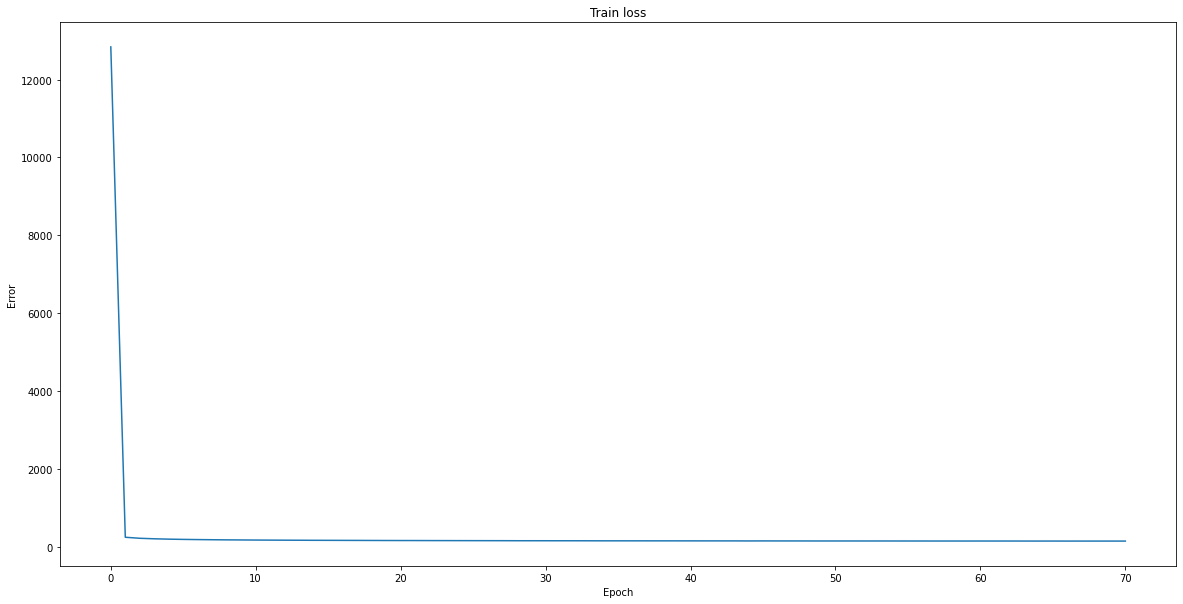

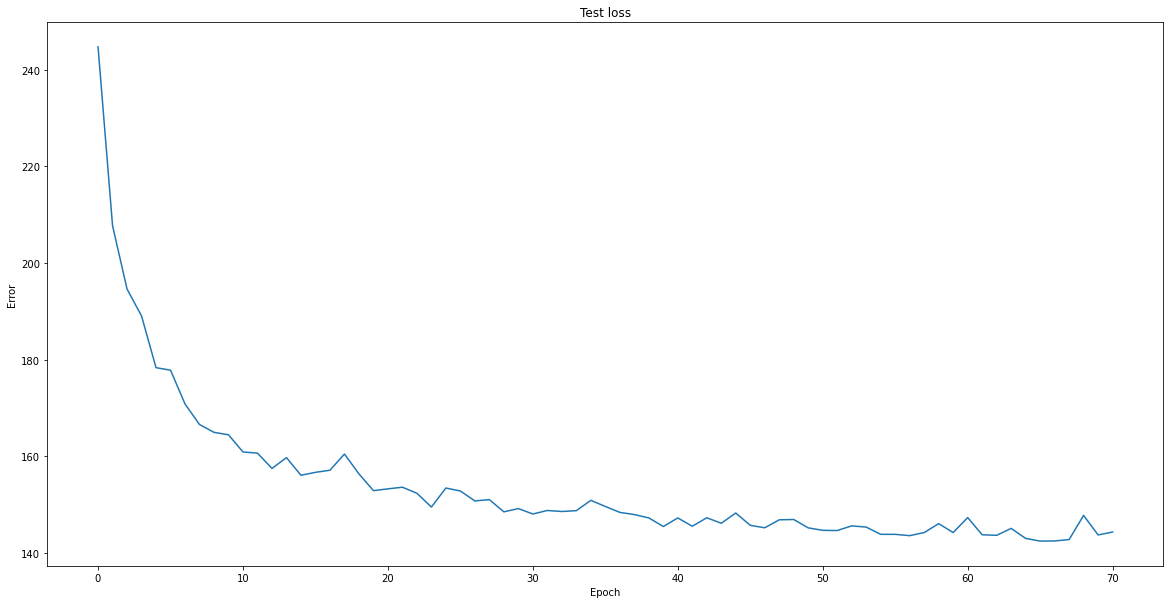

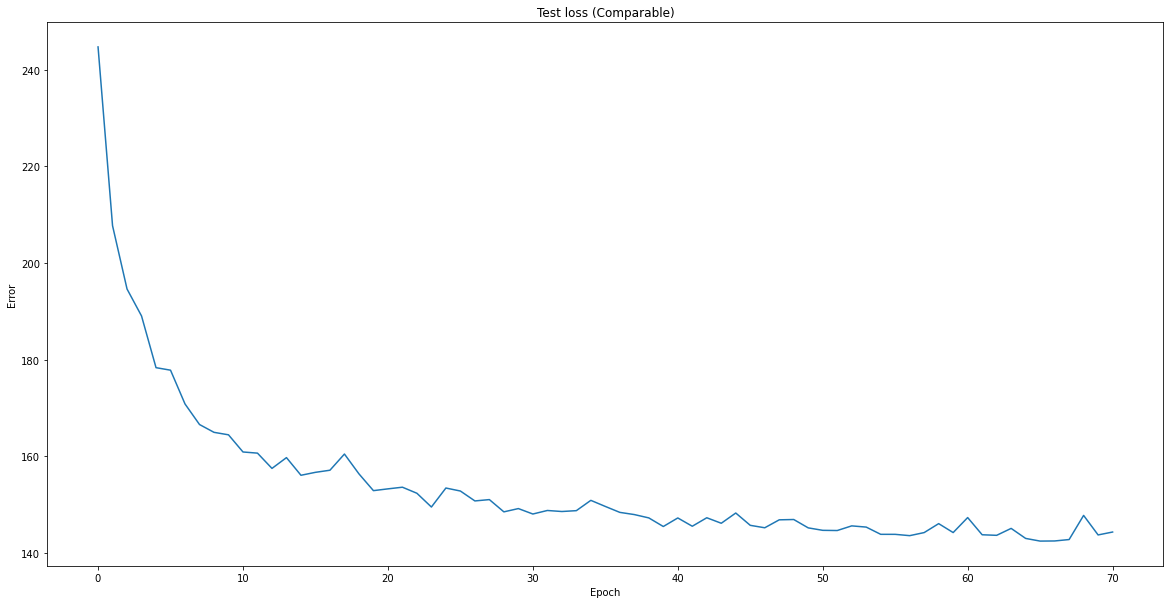

In [9]:
for method in [None]:
    main('sasa_area', method)

In [88]:
def plot_predictions(feature, figname):
    best = {'d4_disp_pint': 'z_std',
            'sasa_area': 'None',
            'xtb_lumo': 'z_std'}
    pname = {'d4_disp_pint': 'D4 Dispersion $P_{int}$',
             'sasa_area': 'SASA',
             'xtb_lumo': 'XTB LUMO'}

    BATCH_SIZE = 512

    checkpoints = glob.glob(f'{DATA_PATH}checkpoints/{feature}_3x256_batch_{best[feature]}/*.pt')
    best_weights = sorted(checkpoints)[0]

    data_train, data_test, reconstruct = get_datasets(feature, best[feature])

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    num_workers = multiprocessing.cpu_count()

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = Net(reconstruct)
    model.load_model(best_weights)
    model = model.to(device)

    def predict_model(loader):
        with torch.no_grad():
            outputs = []
            for batch_idx, (data, label) in enumerate(loader):
                data, label = data.to(device), label.to(device)
                outputs.append(torch.flatten(model(data)))

        return reconstruct(torch.cat(outputs).cpu())

    train_pred = predict_model(train_loader)
    train_actual = reconstruct(data_train.tensors[1])
    test_pred = predict_model(test_loader)
    test_actual = reconstruct(data_test.tensors[1])


    fig, ax = plt.subplots(1, 1, figsize=(8,8), dpi=100)
    ax.set_aspect('equal')

    r2_train = sklearn.metrics.r2_score(train_actual, train_pred)
    r2_test = sklearn.metrics.r2_score(test_actual, test_pred)

    ax.plot(train_actual, train_pred, 'o', label=f'Train ($r^2$: {r2_train: .3f})', alpha=.2)
    ax.plot(test_actual, test_pred, 'o', label=f'Test ($r^2$: {r2_test: .3f})', alpha=.2)
    lim = ax.get_ylim()
    ax.set_xlim(*lim)
    ax.plot(lim, lim, 'k')
    ax.set_ylim(*lim)

    ax.set_xlabel(f'Ground Truth of {pname[feature]}')
    ax.set_ylabel(f'Model Predicton of {pname[feature]}')
    
    if best[feature] == 'None':
        best[feature] = 'No'

    ax.set_title(f'Actual vs Predicted for {pname[feature]} With {best[feature].capitalize()} Normalization')

    ax.legend()
    plt.tight_layout()

    plt.savefig(figname, bbox_inches='tight')

Restoring:
fc1.weight -> 	torch.Size([256, 128]) = 0MB
fc1.bias -> 	torch.Size([256]) = 0MB
fc2.weight -> 	torch.Size([256, 256]) = 0MB
fc2.bias -> 	torch.Size([256]) = 0MB
fc3.weight -> 	torch.Size([1, 256]) = 0MB
fc3.bias -> 	torch.Size([1]) = 0MB
norm1.weight -> 	torch.Size([256]) = 0MB
norm1.bias -> 	torch.Size([256]) = 0MB
norm1.running_mean -> 	torch.Size([256]) = 0MB
norm1.running_var -> 	torch.Size([256]) = 0MB
norm1.num_batches_tracked -> 	torch.Size([]) = 0MB
norm2.weight -> 	torch.Size([256]) = 0MB
norm2.bias -> 	torch.Size([256]) = 0MB
norm2.running_mean -> 	torch.Size([256]) = 0MB
norm2.running_var -> 	torch.Size([256]) = 0MB
norm2.num_batches_tracked -> 	torch.Size([]) = 0MB

Restored all variables
No new variables
Restored /home/isaiah/Documents/PRG/TransVAE/frozen/content/checkpoints/d4_disp_pint_3x256_batch_z_std/068.pt
Restoring:
fc1.weight -> 	torch.Size([256, 128]) = 0MB
fc1.bias -> 	torch.Size([256]) = 0MB
fc2.weight -> 	torch.Size([256, 256]) = 0MB
fc2.bias -> 	to

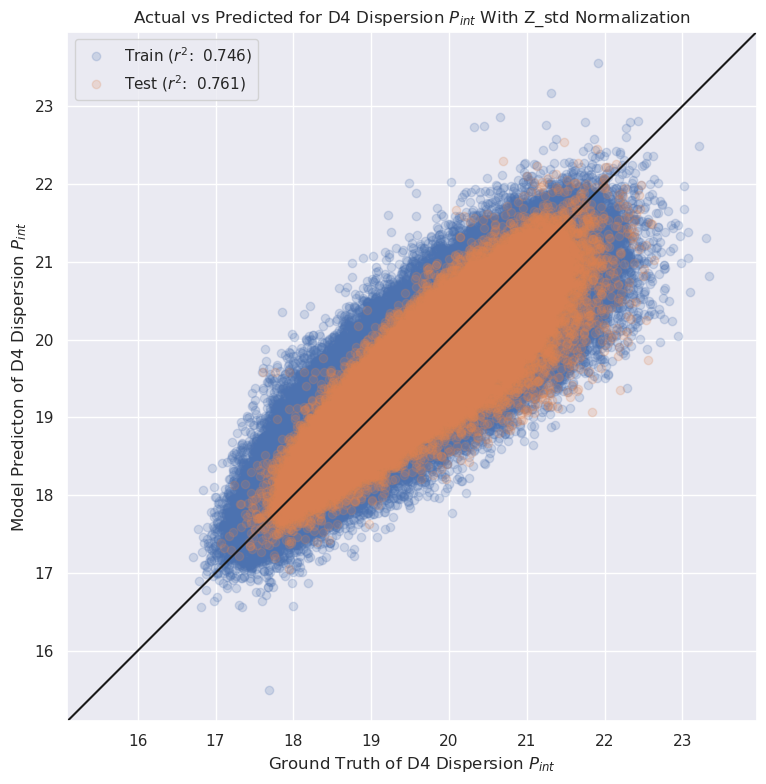

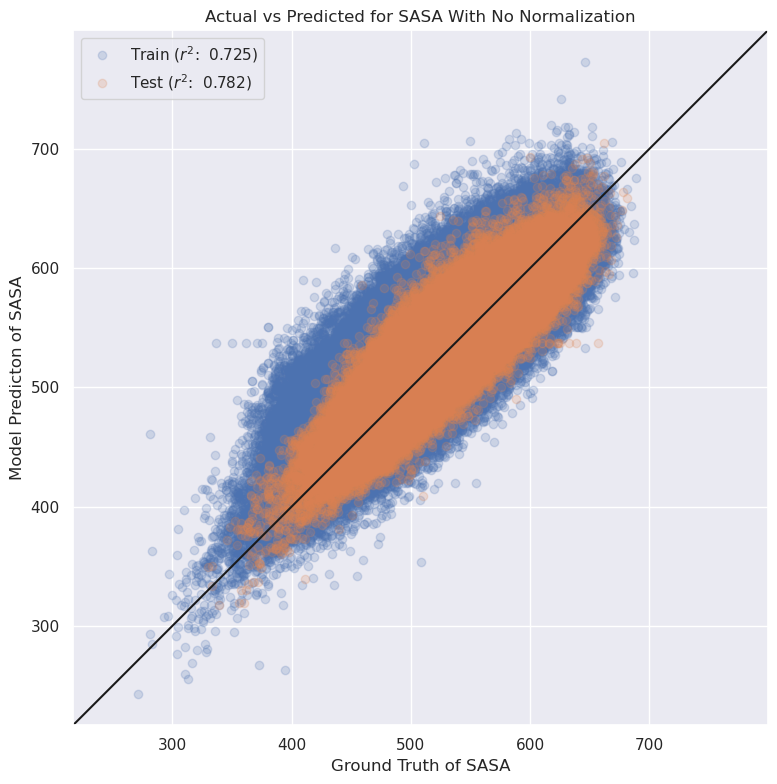

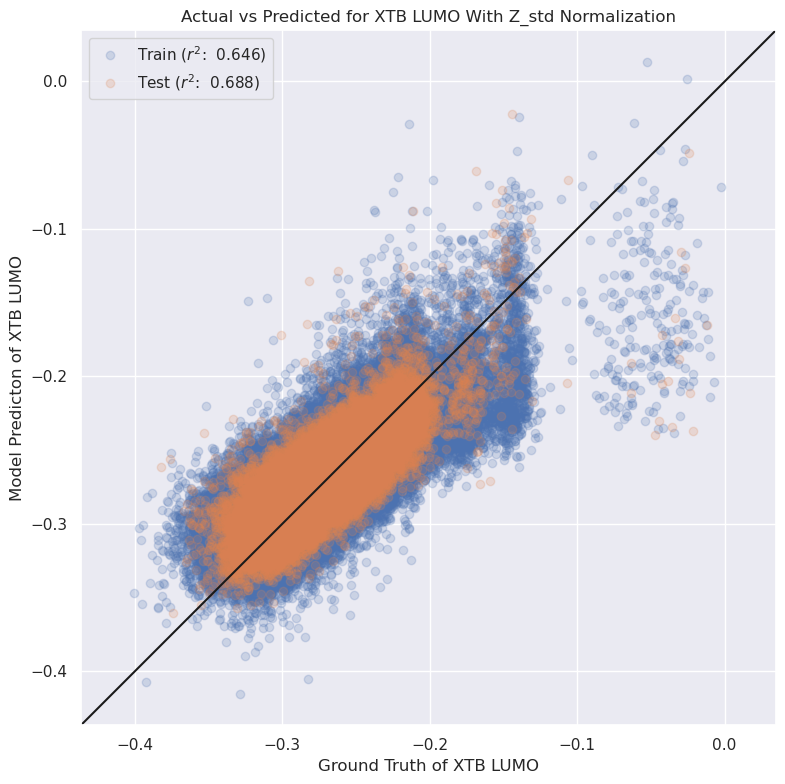

In [90]:
plot_predictions('d4_disp_pint', 'd4_disp_pint_pred.png')
plot_predictions('sasa_area', 'sasa_area_pred.png')
plot_predictions('xtb_lumo', 'xtb_lumo_pred.png')

In [68]:
ax.get_ylim()

(17.71492862701416, 21.566401481628418)